Data Import - Downloads data from Edge Impuse via API

In [98]:
import numpy as np
import requests

API_KEY = 'ei_9d920386ef03de587f12abfd0f3cd9e400cd520c12ef669c5dd6299d6b0763b6'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/43415/training/5/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/43415/training/5/y')


Temperary file store, use Numpy to load it back.

In [99]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

Create data and split Data between Training and Validation Set:

In [100]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "Fan OFF", "Fan ON" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


Model Training:

In [101]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# model architecture
model = Sequential()
model.add(Dense(20, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(Dense(10, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(Dense(classes, activation='softmax', name='y_pred'))

# this controls the learning rate
opt = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(train_dataset, epochs=30, validation_data=validation_dataset, verbose=2, callbacks=callbacks)

history_1=model.fit(train_dataset, epochs=30, validation_data=validation_dataset, verbose=2, callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
1/1 - 1s - loss: 2.2207 - accuracy: 0.5417 - val_loss: 2.6433 - val_accuracy: 0.3333
Epoch 2/30
1/1 - 0s - loss: 2.0149 - accuracy: 0.5417 - val_loss: 2.3634 - val_accuracy: 0.3333
Epoch 3/30
1/1 - 0s - loss: 1.8109 - accuracy: 0.5417 - val_loss: 2.0884 - val_accuracy: 0.3333
Epoch 4/30
1/1 - 0s - loss: 1.6105 - accuracy: 0.5417 - val_loss: 1.8202 - val_accuracy: 0.3333
Epoch 5/30
1/1 - 0s - loss: 1.4152 - accuracy: 0.5417 - val_loss: 1.5618 - val_accuracy: 0.3333
Epoch 6/30
1/1 - 0s - loss: 1.2269 - accuracy: 0.5417 - val_loss: 1.3175 - val_accuracy: 0.3333
Epoch 7/30
1/1 - 0s - loss: 1.0492 - accuracy: 0.5417 - val_loss: 1.0931 - val_accuracy: 0.3333
Epoch 8/30
1/1 - 0s - loss: 0.8863 - accuracy: 0.5417 - val_loss: 0.8968 - val_accuracy: 0.3333
Epoch 9/30
1/1 - 0s - loss: 0.7442 - accuracy: 0.5417 - val_loss: 0.7320 - val_accuracy: 0.3333
Epoch 10/30
1/1 - 0s - loss: 0.6301 - accuracy: 0.5417 - val_loss: 0.6025 - val_accuracy: 0.5000
Epoch 11/30
1/1 - 0s - loss: 0.5463 - a

In [102]:
# Save the model to disk
model.save('saved_model')

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fc36016bc20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Plot Absolute Error

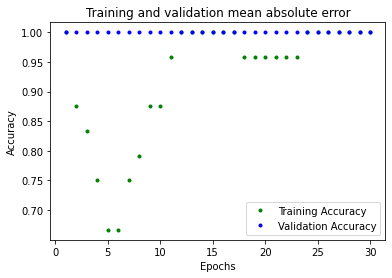

In [105]:
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_accuracy = history_1.history['accuracy']
val_accuracy = history_1.history['val_accuracy']

plt.plot(epochs, train_accuracy, 'g.', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b.', label='Validation Accuracy')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Plot Training vs. Validation Loss

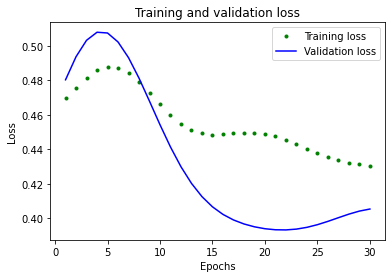

In [104]:
# Matplotlib is a graphing library
import matplotlib.pyplot as plt

# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Predictions vs. Actual Values

1/1 [==============================] - 0s 154ms/step - loss: 0.5055 - accuracy: 1.0000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # This is added back by InteractiveShellApp.init_path()


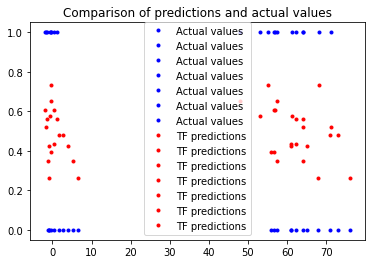

In [90]:
# Calculate and print the loss on our test dataset
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

# Make predictions based on our test dataset
Y_test_pred = model.predict(X_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(X_test, Y_test, 'b.', label='Actual values')
plt.plot(X_test, Y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

Define Files for Tensorflow Lite Conversion

In [72]:
# Define paths to model files
import os
#MODELS_DIR = 'models/'
#if not os.path.exists(MODELS_DIR):
   # os.mkdir(MODELS_DIR)
MODEL_TF = 'saved_model'
MODEL_NO_QUANT_TFLITE = 'model_no_quant.tflite'
MODEL_TFLITE = 'model.tflite'
MODEL_TFLITE_MICRO = 'model.cc'
#MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

Convert to Tensorflow Lite

In [76]:

# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_tflite = converter.convert()

# Save the model to disk
#open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

#Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)


3432

Create C++ Code for Microcontroller

In [77]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

Print C++ Code to copy to Arduino Header File

In [78]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x20, 0x00, 0x00, 0x00, 0x40, 0x01, 0x00, 0x00,
  0x20, 0x00, 0x00, 0x00, 0xe8, 0x00, 0x00, 0x00, 0x50, 0x00, 0x00, 0x00,
  0x02, 0x00, 0x00, 0x00, 0x30, 0x04, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x44, 0x01, 0x00, 0x00, 0x0d, 0x00, 0x00, 0x00,
  0x10, 0x0d, 0x00, 0x00, 0x0c, 0x0d, 0x00, 0x00, 0x44, 0x0c, 0x00, 0x00,
  0xcc, 0x0b, 0x00, 0x00, 0x38, 0x0b, 0x00, 0x00, 0xb4, 0x08, 0x00, 0x00,
  0x40, 0x05, 0x00, 0x00, 0x9c, 0x04, 0x00, 0x00, 0xf0, 0x0c, 0x00, 0x00,
  0xec, 0x0c, 0x00, 0x00, 0xe8, 0x0c, 0x00, 0x00, 0xe4, 0x0c, 0x00, 0x00,
  0xcc, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x0c, 0x